In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import qiime2 as q2
import numpy as np
%matplotlib inline
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

data_dir = 'data' #data from polybox (ASV, taxonomy analysis)
or_dir = '../data'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

In [ ]:
! wget -nv -O $data_dir/taxonomy_classification.qzv 'https://polybox.ethz.ch/index.php/s/c3rjz7z9GBUXvE8/download'
! wget -nv -O $data_dir/taxonomy_classification.qza 'https://polybox.ethz.ch/index.php/s/X8AoIryeOnLaCn5/download'
! wget -nv -O $data_dir/PJNB_dada2_table-filtered.qza 'https://polybox.ethz.ch/index.php/s/q2dsg2JxeJz3hko/download'
! wget -nv -O $data_dir/PJNB_dada2_rep_set-filtered.qza 'https://polybox.ethz.ch/index.php/s/vtDJzaCrmebL2u7/download'

In [ ]:
#! qiime tools extract \
#    --input-path $data_dir/taxa-bar-plots-filtered.qzv \
#    --output-path $data_dir/extracted-taxa-bar-filtered

In [2]:
metadata = pd.read_csv(or_dir + '/metadata.tsv', sep = '\t')

In [3]:
print(metadata.shape, ' the number of samples we have and metadata variables that were collected')
print(metadata['host_id'].nunique(), ' unique hosts tracked over time') # number of hosts that were followed over time
print(metadata.columns)

(1669, 26)  the number of samples we have and metadata variables that were collected
80  unique hosts tracked over time
Index(['id', 'Library Layout', 'Instrument', 'collection_date',
       'geo_location_name', 'geo_latitude', 'geo_longitude', 'host_id',
       'age_days', 'weight_kg', 'length_cm', 'WAZ', 'HAZ', 'WHZ', 'BMI',
       'birth_weight_g', 'birth_length_cm', 'sex', 'delivery_mode', 'zygosity',
       'race', 'ethnicity', 'delivery_preterm', 'diet_milk', 'diet_weaning',
       'age_months'],
      dtype='object')


## Loading taxonomy assignments file
QUESTION: how to download csv from qiime 2 taxa barplot to wanted level and with metadata info. Now did manually from the output visualization. 

In [4]:
taxonomic_assignments = pd.read_csv(data_dir+'/taxonomic_assignments.csv', index_col = 0) # import metadata with taxonomic assignment dataframe
print(taxonomic_assignments.shape)
#print(taxonomic_assignments.head())
taxonomic_assignments = taxonomic_assignments[taxonomic_assignments['diet_milk'] != 'no milk']
# REMOVED no milk, not specified what they mean, are the babies ill so getting food via infuse
# or did the mother run out of milk, does this then mean the babies are on formula?
# or are they on solid food?
print(taxonomic_assignments['diet_weaning'].unique(), ' possible values of diet weaning')
print(taxonomic_assignments['diet_milk'].unique(), ' possible values of diet milk')
print(taxonomic_assignments.shape)

(1669, 364)
[nan True False]  possible values of diet weaning
[nan 'bd' 'fd']  possible values of diet milk
(1639, 364)


In [5]:
col_names = taxonomic_assignments.columns
col_names_species = col_names[0:-25] #remove metadata columns, get all species
#print(col_names_species)
print(len(col_names_species), 'total number of taxonomies, all levels')
col_names_species = [i for i in col_names_species if not i.endswith('__')] #remove taxonomies unclassfied until species
print(len(col_names_species), 'species were identified in total')
metadata_cols = col_names[-25:] #columns with metadata info
print(metadata_cols)
print(taxonomic_assignments[col_names_species].sum(axis=1).describe()) # for each sample the total number of species abundances

339 total number of taxonomies, all levels
140 species were identified in total
Index(['Library Layout', 'Instrument', 'collection_date', 'geo_location_name',
       'geo_latitude', 'geo_longitude', 'host_id', 'age_days', 'weight_kg',
       'length_cm', 'WAZ', 'HAZ', 'WHZ', 'BMI', 'birth_weight_g',
       'birth_length_cm', 'sex', 'delivery_mode', 'zygosity', 'race',
       'ethnicity', 'delivery_preterm', 'diet_milk', 'diet_weaning',
       'age_months'],
      dtype='object')
count     1639.000000
mean      5628.410006
std       2659.443285
min          2.000000
25%       3831.000000
50%       5419.000000
75%       7080.500000
max      18401.000000
dtype: float64


## Strings for diet, no Booleans, no NaN

In [6]:
taxonomic_assignments['diet_weaning'] = taxonomic_assignments['diet_weaning'].replace({True: 'weaning', False:'not weaning'})
taxonomic_assignments['diet_weaning'] = taxonomic_assignments['diet_weaning'].fillna('weaned')
taxonomic_assignments['diet_milk'] = taxonomic_assignments['diet_milk'].fillna('weaned')
print(taxonomic_assignments['diet_weaning'].unique())
print(taxonomic_assignments['diet_milk'].unique())

['weaned' 'weaning' 'not weaning']
['weaned' 'bd' 'fd']


## Questions about data
A. Do all hosts go through weaning? 
    
    A: Yes
    
B. How many hosts switch back and forth 1 or more times between weaning True/False or NaN?
    
    B: 61 for weaning, 51 for milk. 
    
C. What is the distribution of diets?

    A: See bar plot
D. Do they still mention the milk type while weaning?

E. Filter metadata file to contain only all timepoints not weaning (first continuous timepoints and then fully weaned continuous timepoints) So remove all timepoints where are switching between not weaning / weaning and weaning / weaned, so stable microbiome can be reached and then can use this to compare the microbiomes of monozygotic and dizygotic twins. 

F. How many missing values are there for diet_milk and diet_weaning before 12 months?

In [9]:
###A.
host_numbers = taxonomic_assignments['host_id'].unique()
for host in host_numbers:
    df = taxonomic_assignments[taxonomic_assignments['host_id'] == host]
    if (df['diet_weaning'] == 'weaning').sum() == 0:
        print(host, 'did not wean')

In [11]:
### D.
def collapse_consec_values(series): # function to collapse consecutive identical values into 1 
    # e.g. ['not weaning', 'weaning', 'weaning', 'weaning', 'weaned', 'weaning']
    # into ['not weaning', 'weaning', 'weaned', 'weaning']
    series = list(series)
    new = []; new.append(series[0])
    indices = []; indices.append(0)
    for i in range(1, len(series)):
        if series[i] != series[i-1]:
            new.append(series[i])
            indices.append(i) # log index of first time you see a state or repeat a state
    return new, indices

#print(metadata.head())
metadata['diet_weaning'] = metadata['diet_weaning'].replace({True: 'weaning', False:'not weaning'})
metadata['diet_weaning'] = metadata['diet_weaning'].fillna('weaned')
twins_numbers = np.unique(np.array([round(x) for x in host_numbers]))
def collapse(metadata, host):
    df = metadata[metadata['host_id'] == host]
    ages = df['age_days']
    ages = ages.sort_values()
    df = df.loc[ages.index, ] # sort by age
    weanings, weanings_ind = collapse_consec_values(df['diet_weaning'])
    #print(df[['age_days','diet_weaning', 'host_id', 'id']])
    #print(ages.iloc[weanings_ind])
    return weanings,weanings_ind, len(ages)

def get_id(metadata, host, ind):
    df = metadata[metadata['host_id'] == host]
    ages = df['age_days']
    ages = ages.sort_values()
    df = df.loc[ages.index, ] # sort by age
    return df['id'].iloc[ind]

ids_keep = list()
for twins in twins_numbers:
    #twins = 14
    weanings1, weanings_ind1, length1 = collapse(metadata, twins+0.1)
    weanings2, weanings_ind2, length2 = collapse(metadata, twins+0.2)
    #print(weanings1)
    #print(weanings2)
    #print(weanings_ind1)
    #print(weanings_ind2)

    try:
        first_not1 = weanings_ind1[weanings1.index('not weaning')]
        first_not2 = weanings_ind2[weanings2.index('not weaning')]
        last_not1 = weanings_ind1[weanings1.index('not weaning')+1]-1
        last_not2 = weanings_ind2[weanings2.index('not weaning')+1]-1

        first_weaned1 = weanings_ind1[len(weanings1) - 1 - weanings1[::-1].index('weaned')]
        first_weaned2 = weanings_ind2[len(weanings2) - 1 - weanings2[::-1].index('weaned')]
        #print(first_not1)
        #print(first_not2)

        #print(last_not1)
        #print(last_not2)

        #print(first_weaned1)
        #print(first_weaned2)

        notweaning_overlap = list(range(max(first_not1,first_not2), min(last_not1, last_not2)+1))
        weaned_overlap = list(range(max(first_weaned1,first_weaned2), min(length1, length2)+1))

        #print(notweaning_overlap)
        #print(weaned_overlap)
        ids_keep.extend(list(get_id(metadata, twins+0.1, range(first_not1, last_not1+1))))
        ids_keep.extend(list(get_id(metadata, twins+0.2, range(first_not2, last_not2+1))))

        ids_keep.extend(list(get_id(metadata, twins+0.1, range(first_weaned1, length1))))
        ids_keep.extend(list(get_id(metadata, twins+0.2, range(first_weaned2, length2))))

    except: pass
print(len(ids_keep), ' number of samples we kept after filtering out timepoints where were switching between not weanign and weaning or weaning and weaned')

#print(metadata.loc[metadata['id'].isin(ids_keep), :])
metadata_not_weaning_weaned = metadata.loc[metadata['id'].isin(ids_keep), :] 
# filter the metadata to contain only samples: were not weaning, first consecutive timepoints
# or were fully weaned, last consecutive timepoints. 
metadata_not_weaning_weaned = metadata_not_weaning_weaned.sort_values('host_id')
metadata_not_weaning_weaned.to_csv(data_dir+'/metadata_only_before_after_weaning.csv', index = False)#, index_label=None)
print(metadata_not_weaning_weaned['diet_weaning'].value_counts())
print(metadata_not_weaning_weaned['host_id'].unique(), metadata_not_weaning_weaned['host_id'].nunique(), ' unique host ids left')


# verify that the code worked, should only see not weaning, weaned. 
for host in metadata_not_weaning_weaned['host_id'].unique():
    weanings1, weanings_ind1, length1 = collapse(metadata_not_weaning_weaned, host)
    print(weanings1)
    print(weanings_ind1)

857  number of samples we kept after filtering out timepoints where were switching between not weanign and weaning or weaning and weaned
weaned         716
not weaning    141
Name: diet_weaning, dtype: int64
[ 2.1  2.2  3.1  3.2  5.1  5.2  6.1  6.2  8.1  8.2 12.1 12.2 13.1 13.2
 14.1 14.2 15.1 15.2 16.1 16.2 17.1 17.2 18.1 18.2 20.1 20.2 21.1 21.2
 23.1 23.2 24.1 24.2 25.1 25.2 27.1 27.2 28.1 28.2 30.1 30.2 32.1 32.2
 33.1 33.2 36.1 36.2 39.1 39.2 40.1 40.2 42.1 42.2 43.1 43.2 44.1 44.2
 45.1 45.2 46.1 46.2] 60  unique host ids left
['not weaning', 'weaned']
[0, 1]
['not weaning', 'weaned']
[0, 1]
['not weaning', 'weaned']
[0, 3]
['not weaning', 'weaned']
[0, 3]
['not weaning', 'weaned']
[0, 1]
['not weaning', 'weaned']
[0, 2]
['not weaning', 'weaned']
[0, 1]
['not weaning', 'weaned']
[0, 3]
['not weaning', 'weaned']
[0, 1]
['not weaning', 'weaned']
[0, 3]
['not weaning', 'weaned']
[0, 3]
['not weaning', 'weaned']
[0, 4]
['not weaning', 'weaned']
[0, 3]
['not weaning', 'weaned']
[0, 2]

In [13]:
###B.
def count_back_switches(collapsed, ind, series): # assume weaning False, True, NaN is normal order
    # baby goes from drinking milk, to switching to solid food, to eating only solid food
    # however sometimes there's trial and error so need can repeat states
    # find 1st occurrence of weaning False, then last of weaning True and NaN
    collapsed = np.array(collapsed)
    coll_un = np.unique(collapsed)
    for states in coll_un:
        if states == 'not weaning': weaning_false_ind = np.argwhere(collapsed == 'not weaning')[0][0]
        if states == 'weaning': 
            weaning_true_ind1 = np.argwhere(collapsed =='weaning')[-1][0]
            weaning_true_ind2 = np.argwhere(collapsed =='weaning')[0][0]
        if states == 'weaned': weaned_ind = np.argwhere(collapsed == 'weaned')[-1][0]
    if len(coll_un) == 3:
        return np.array([ ind[weaning_true_ind1] - ind[weaning_false_ind+1], ind[weaned_ind] - ind[weaning_true_ind2+1] ])
    # count the first repeats as repeats, count the last repeats as repeats
    if 'not weaning' not in coll_un:
        print('only weaning and weaned')
        return np.array([ ind[weaning_true_ind1], ind[weaned_ind] - ind[weaning_true_ind2+1] ])
    if 'weaned' not in coll_un:
        print('only not weaning and weaning')
        return np.array([ ind[weaning_true_ind1] - ind[weaning_false_ind+1], len(series) - ind[weaning_true_ind2 + 1] ])
    
def count_back_switches_milk(series): # assume weaning False, True, NaN is normal order
    # baby goes from drinking milk, to switching to solid food, to eating only solid food
    # however sometimes there's trial and error so need can repeat states
    # find 1st occurrence of weaning False, then last of weaning True and NaN
    series = series.replace({'fd':'milk','bd':'milk', 'weaned':'weaned'})
    collapsed, ind =  collapse_consec_values(series)
    if len(np.unique(np.array(collapsed))) < len(collapsed):
        collapsed = np.array(collapsed)
        coll_un = np.unique(collapsed)
        for states in coll_un:
            if states == 'milk': weaning_false_ind = np.argwhere(collapsed == 'milk')[0][0]
            if states == 'weaned': 
                weaned_ind1 = np.argwhere(collapsed == 'weaned')[-1][0]
                weaned_ind2 = np.argwhere(collapsed == 'weaned')[0][0]
        if len(coll_un) == 2:
            return np.array([ ind[weaned_ind1] - ind[weaning_false_ind+1], len(series) - ind[weaned_ind2+1] ])
    else: return np.array([0,0])

a=0
total_switch_weaning=0
number_switch_weaning=0
num_total_switch_weaning = np.array([0,0])
total_switch_milk=0 # fact that the host switched between modes at least once or not
number_switch_milk=0 # number of extra switches in each host, summed
num_total_switch_milk= np.array([0,0])

for host in host_numbers:
    df = taxonomic_assignments[taxonomic_assignments['host_id'] == host]
    ages = df['age_days']
    ages = ages.sort_values()
    df = df.loc[ages.index, ] # sort by age
    weanings, weanings_ind = collapse_consec_values(df['diet_weaning'])
    
    if weanings != ['not weaning', 'weaning', 'weaned']: #expected normal sequence
        # note that some babies have only some timepoints e.g. not weaning or ['weaning', 'weaned']
        #print(weanings); print(host)
        b = 1
    
    try: # check if NaN is also used as entry before first occurrence of not weaning (weaning False)
        # luckily this is not the case
        if weanings.index('weaned') < weanings.index('not weaning'):
            print(weanings); print(host)
            print(' has NaN value before first occurrence of weaning False')
    except: pass
    
    if len(np.unique(np.array(weanings))) < len(weanings):
        total_switch_weaning = total_switch_weaning + 1
        number_switch_weaning = number_switch_weaning + len(weanings) - len(np.unique(np.array(weanings)))
        num_total_switch_weaning = num_total_switch_weaning + count_back_switches(weanings, weanings_ind, df['diet_weaning'])
        
    milk, milk_ind = collapse_consec_values(df['diet_milk'])
    print(milk)
    if len(np.unique(np.array(milk))) < len(milk):
        #print(milk)
        total_switch_milk = total_switch_milk + 1
        number_switch_milk = number_switch_milk+ len(milk) - len(np.unique(np.array(milk)))
        num_total_switch_milk = num_total_switch_milk + count_back_switches_milk(df['diet_milk'])
    #print(milk)
    
    if len(ages.unique()) < len(ages):
        print(host)
        a=a+1
print(a, ' repeat measurements for one age (days)')
print(total_switch_weaning, ' number of hosts that switch back and forth between weaning and/or not weaning and/or NaN')
print(total_switch_milk, ' number of hosts that switch back and forth between breast milk and/or formula and/or no milk and/or NaN')

print(number_switch_weaning, ' number of times a weaning mode is repeated after another (not taking into account consecutive instances, they count as one)')
print(number_switch_milk, ' number of times a milk feeding mode is repeated after another (not taking into account consecutive instances, they count as one)')

print(num_total_switch_weaning, ' number of times a weaning mode is repeated after another (taking into account consecutive instances)')
print(num_total_switch_milk, ' number of times a milk mode is repeated after another (taking into account consecutive instances)')

['bd', 'weaned']
['bd', 'weaned']
['fd', 'weaned']
['fd', 'weaned']
['fd', 'weaned']
['fd', 'weaned']
['fd', 'weaned', 'fd', 'weaned']
['fd', 'weaned', 'fd', 'weaned']
['bd', 'fd', 'weaned']
['bd', 'fd', 'weaned']
['fd', 'weaned']
['fd', 'weaned']
['bd', 'fd', 'weaned']
['bd', 'fd', 'weaned', 'fd', 'weaned']
['fd', 'weaned']
['bd', 'fd', 'weaned']
['fd', 'bd', 'fd', 'bd', 'weaned']
['bd', 'fd', 'bd', 'fd', 'bd', 'fd', 'weaned']
['bd', 'fd', 'weaned', 'fd', 'weaned']
['bd', 'fd', 'weaned']
['bd', 'fd', 'weaned']
['bd', 'fd', 'weaned']
['fd', 'weaned']
['fd', 'weaned']
['fd', 'weaned']
['bd', 'fd', 'weaned']
['bd', 'fd', 'weaned']
['fd', 'weaned']
only weaning and weaned
['fd', 'weaned', 'fd']
['fd']
['bd', 'weaned']
['bd', 'weaned']
['fd', 'weaned', 'fd', 'weaned']
['fd']
['fd']
['bd', 'weaned']
['bd', 'fd', 'weaned', 'fd', 'weaned']
['fd', 'weaned', 'fd', 'weaned']
['bd', 'fd', 'weaned', 'fd', 'weaned']
['bd', 'fd', 'weaned', 'fd', 'weaned']
only weaning and weaned
['fd', 'weaned', 'fd

In [ ]:
# DEBUGGING, DELETE WHEN DONE
series = df['diet_milk']
series = series.replace({'fd':'milk','bd':'milk', 'weaned':'weaned'})
collapsed, ind =  collapse_consec_values(series)
if len(np.unique(np.array(collapsed))) < len(collapsed):
    collapsed = np.array(collapsed)
    coll_un = np.unique(collapsed)
    for states in coll_un:
        if states == 'milk': weaning_false_ind = np.argwhere(collapsed == 'milk')[0][0]
        if states == 'weaned': 
            weaned_ind1 = np.argwhere(collapsed == 'weaned')[-1][0]
            weaned_ind2 = np.argwhere(collapsed == 'weaned')[0][0]
    if len(coll_un) == 2:
        a= np.array([ ind[weaned_ind1] - ind[weaning_false_ind+1], len(series) - ind[weaning_true_ind2+1] ])



In [ ]:
###C.
plt.figure()
taxonomic_assignments['diet_weaning'].value_counts().plot(kind='bar')
plt.figure()
taxonomic_assignments['diet_milk'].value_counts().plot(kind='bar')

In [26]:
### F.
df = taxonomic_assignments
print(df.loc[((df['diet_milk'] == 'weaned') & (df['age_months'] < 5))].shape[0], ' number of NaN values for diet weaning that correspond to age 5 months and younger')
print(df.loc[((df['diet_milk'] == 'weaned') & (df['age_months'] < 12))].shape[0], ' number of NaN values for diet weaning that correspond to age 12 months and younger')


0  number of NaN values for diet weaning that correspond to age 5 months and younger
24  number of NaN values for diet weaning that correspond to age 12 months and younger


## Decision tree classifier for milk diet and for weaning

In [52]:
def metrics(model, target, predictor):
    cv_predict = cross_val_predict(model, predictor, target, cv=5)
    class_report = classification_report(target, cv_predict, output_dict = True)
    print(classification_report(target, cv_predict, output_dict = False)) #, target_names=target_names))
    #print(class_report.index)
    conf_matrix = pd.DataFrame(confusion_matrix(target, cv_predict))
    conf_matrix.columns = list(class_report.keys())[0:-3]
    conf_matrix['index'] = list(class_report.keys())[0:-3]
    conf_matrix.set_index('index', inplace = True)
    print(conf_matrix)
    
def DTC(target, predictor):
    clf = DecisionTreeClassifier(random_state=42)#, max_depth = 50, min_samples_split = 0.01)
    cv_clf_milk = cross_val_score(clf, predictor, target, cv=5)
    print(round(sum(cv_clf_milk)/len(cv_clf_milk)*100,2), ' percentage of classes that were correctly predicted in cross validation')
    metrics(clf, target, predictor)

In [ ]:
DTC(taxonomic_assignments['diet_milk'], taxonomic_assignments[col_names_species])
DTC(taxonomic_assignments['diet_weaning'], taxonomic_assignments[col_names_species])

In [ ]:
taxonomic_assignments[col_names_species].isnull().sum().sum()

## Random Forest Classifier

In [53]:
def RFC(target, predictor):
    rfc = RandomForestClassifier(random_state=42)#, max_depth = 50, min_samples_split = 0.01)
    #target = taxonomic_assignments['diet_milk'].fillna('weaned')
    cv_rfc_milk = cross_val_score(rfc, predictor, target, cv=10)
    print(round(sum(cv_rfc_milk)/len(cv_rfc_milk)*100,2), ' percentage of classes that were correctly predicted in cross validation')
    metrics(rfc, target, predictor)

In [ ]:
RFC(taxonomic_assignments['diet_milk'], taxonomic_assignments[col_names_species])
RFC(taxonomic_assignments['diet_weaning'], taxonomic_assignments[col_names_species])

## SVM

In [54]:
def SVMC(target, predictor):
    clf = svm.SVC(random_state=42, kernel = 'rbf', C = 1) # kernel can also be rbf, linear or poly
    # can set C = something less than 1 to regularize, prevent overfitting as have more parameters than 
    cv_clf_milk = cross_val_score(clf, predictor, target, cv=5)
    print(round(sum(cv_clf_milk)/len(cv_clf_milk)*100,2), ' percentage of classes that were correctly predicted in cross validation')
    metrics(clf, target, predictor)

In [ ]:
SVMC(taxonomic_assignments['diet_milk'], taxonomic_assignments[col_names_species])
SVMC(taxonomic_assignments['diet_weaning'], taxonomic_assignments[col_names_species])

## Ideas
* transform counts to fractions
* ASV instead of taxonomic assignment
* classifier: k-means, GMM (even though not Gaussian :/), Bayes, SVM
* Dimensionality reduction: either PCA or one of those or use decision tree to get most important features/species for this classification task
* try different taxonomic levels (now have only species)
* could select features with decision tree and then build NN classifier
* Which classes are being missclassified by these models?
* Could we infer response time to change in diet of microbiome from the relapsing into weaning/not weaning/weaned in the transition period?
* Build classifier for the zygosity: build one for the first 5 months, then 5-12 then 12 and more. 3 classes: mono, di, not related, make it balanced. If this classifier does well, then it means the genetics have an influence on the microbiome. Input: the taxonomic assignment/ASV of 2 babies. 

## Repeat analysis using fractions of abundance per species

In [ ]:
taxonomic_assignments_frac = taxonomic_assignments[col_names_species].div(taxonomic_assignments[col_names_species].sum(axis=1), axis=0)

In [ ]:
DTC(taxonomic_assignments['diet_milk'], taxonomic_assignments_frac)
DTC(taxonomic_assignments['diet_weaning'], taxonomic_assignments_frac)

RFC(taxonomic_assignments['diet_milk'], taxonomic_assignments_frac)
RFC(taxonomic_assignments['diet_weaning'], taxonomic_assignments_frac)

## PCA + standardize

In [55]:
from sklearn.preprocessing import StandardScaler

def scaler(df, cols):
    taxonomic_assignments_normal = pd.DataFrame(StandardScaler().fit_transform(df[cols]))
    taxonomic_assignments_normal.columns = df[cols].columns
    taxonomic_assignments_normal.set_index(df[cols].index, inplace = True)
    return taxonomic_assignments_normal
taxonomic_assignments_normal = scaler(taxonomic_assignments, col_names_species)

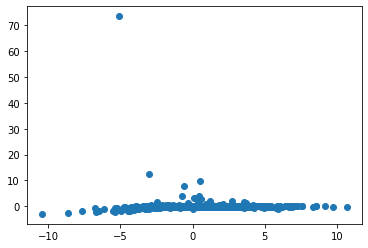

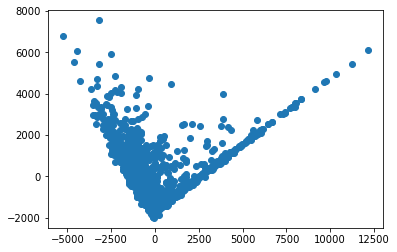

In [56]:
from sklearn.decomposition import PCA
def PCA_apply(df, cols):
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(df[cols])
    principalComponents = pd.DataFrame(principalComponents)
    principalComponents.set_index(df[cols].index, inplace = True)

    #print(principalComponents.describe())
    #print(principalComponents.head())
    
    plt.figure(); plt.scatter(principalComponents.iloc[:,0], principalComponents.iloc[:,1])
    return principalComponents

principalComponents = PCA_apply(taxonomic_assignments_normal, col_names_species)
principalComponents_notnormal = PCA_apply(taxonomic_assignments, col_names_species)

In [ ]:
RFC(taxonomic_assignments['diet_milk'], principalComponents_notnormal)
RFC(taxonomic_assignments['diet_weaning'], principalComponents_notnormal)

{'weaning': 'red', 'not weaning': 'green', 'weaned': 'blue'}
{'weaning': 'red', 'not weaning': 'green', 'weaned': 'blue'}


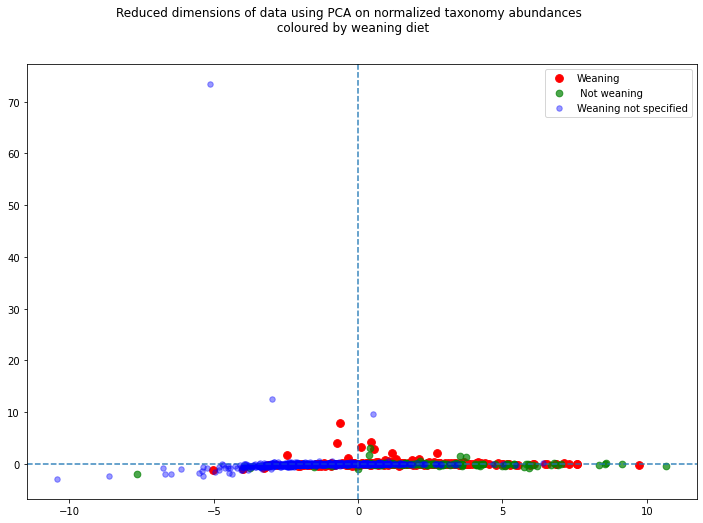

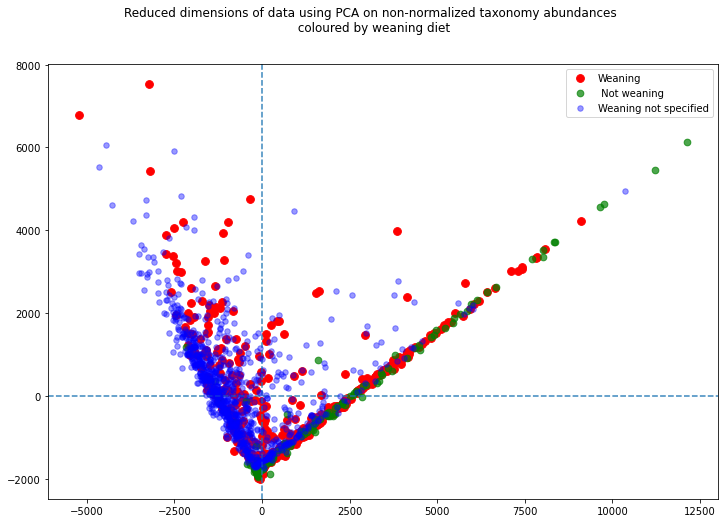

In [57]:
def pca_weaning_plot(taxonomies, principalComponents, title):
    colours_weaning = {'weaning':'red', 'not weaning':'green', 'weaned':'blue'}#, 'other':'black'}
    print(colours_weaning)
    labels = ['Weaning', ' Not weaning', 'Weaning not specified']
    fig, ax = plt.subplots(figsize = (12,8))
    i=0
    for key in colours_weaning:
        indices = (taxonomies['diet_weaning'] == key)
        #print(key)
        #print(len(indices))
        PCAs = principalComponents.loc[indices, ]
        ax.scatter(PCAs.iloc[:,0], PCAs.iloc[:,1], 
                   color = colours_weaning[key], label = labels[i], s = 60-i*15,
                   zorder = i, alpha = 1-i*0.3)
        ax.axhline(0, linestyle = '--', alpha = 0.4)
        ax.axvline(0, linestyle = '--', alpha = 0.4)
        i=i+1
    ax.legend()
    fig.suptitle('Reduced dimensions of data using ' + title + ' \n coloured by weaning diet')
    #ax.set_ylim([-5, 15]) #one outlier at 70

pca_weaning_plot(taxonomic_assignments, principalComponents, 'PCA on normalized taxonomy abundances')
pca_weaning_plot(taxonomic_assignments, principalComponents_notnormal, 'PCA on non-normalized taxonomy abundances')

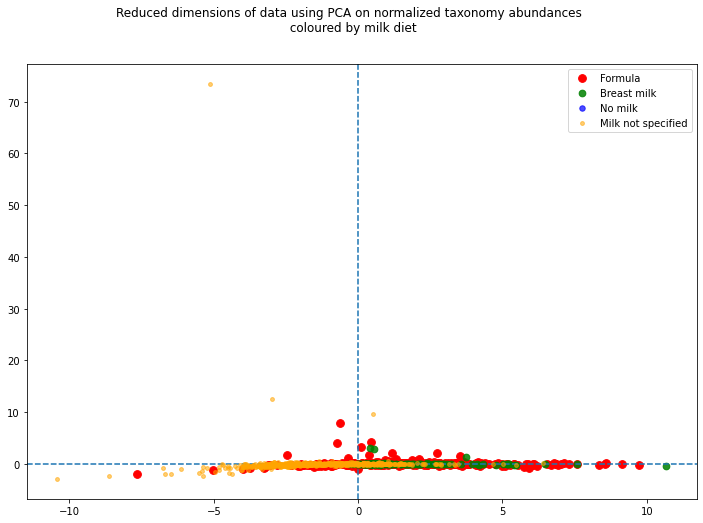

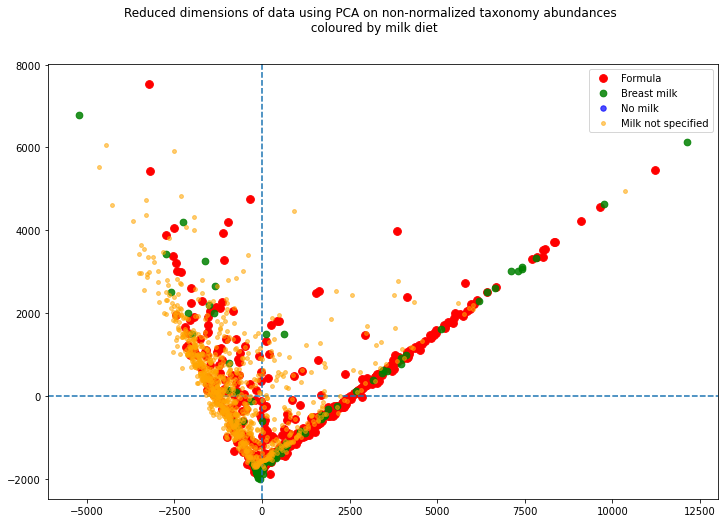

In [58]:
def pca_milk_plot(taxonomies, principalComponents, title):
    color_formula_breast = {'fd': 'red', 'bd': 'green', 'no milk': 'blue', 'weaned': 'orange'}
    labels = ['Formula', 'Breast milk', 'No milk', 'Milk not specified']

    fig, ax = plt.subplots(figsize = (12,8))
    i=0
    for key in color_formula_breast:
        indices = (taxonomies['diet_milk'] == key)
        PCAs = principalComponents.loc[indices, ]
        ax.scatter(PCAs.iloc[:,0], PCAs.iloc[:,1], 
                   color = color_formula_breast[key], label = labels[i], s = 60-i*15,
                    zorder = i, alpha = 1-i*0.15)
        ax.axhline(0, linestyle = '--', alpha = 0.4)
        ax.axvline(0, linestyle = '--', alpha = 0.4)
        i=i+1
    ax.legend()
    fig.suptitle('Reduced dimensions of data using ' + title + ' \n coloured by milk diet')
    #ax.set_ylim([-5, 15]) #one outlier at 70

pca_milk_plot(taxonomic_assignments, principalComponents, 'PCA on normalized taxonomy abundances')
pca_milk_plot(taxonomic_assignments, principalComponents_notnormal, 'PCA on non-normalized taxonomy abundances')

### Effect of removing outlier in PCA
Did not allow for clustering. 

In [ ]:
#plt.scatter(np.log(principalComponents.iloc[:,0]), np.log(principalComponents.iloc[:,1]))
ind_outlier = principalComponents[principalComponents[1] > 15].index
principalComponents.loc[ind_outlier,]

In [ ]:
taxonomic_assignments_no_outlier_normal = taxonomic_assignments.drop(index = ind_outlier, inplace = False)
taxonomic_assignments_no_outlier_normal = scaler(taxonomic_assignments_no_outlier_normal, col_names_species)
principalComponents_no_outlier = PCA_apply(taxonomic_assignments_no_outlier_normal, col_names_species)
pca_weaning_plot(taxonomic_assignments.drop(index = ind_outlier, inplace = False), principalComponents_no_outlier, 'PCA on normalized taxonomy abundances without 1 outlier')

## t-SNE

In [62]:
def fit_tSNE(data):
    X_embedded = TSNE(n_components=2, learning_rate=200,
                   init='random', perplexity=5).fit_transform(data)
    X_embedded = pd.DataFrame(X_embedded)
    X_embedded.set_index(data.index, inplace = True)
    return X_embedded

t_SNE_taxonomy = fit_tSNE(taxonomic_assignments_normal)
t_SNE_taxonomy_notnormal = fit_tSNE(taxonomic_assignments[col_names_species])

In [ ]:
pca_weaning_plot(taxonomic_assignments, t_SNE_taxonomy, 't-SNE on normalized taxonomy abundances')
pca_milk_plot(taxonomic_assignments, t_SNE_taxonomy, 't-SNE on normalized taxonomy abundances')

pca_weaning_plot(taxonomic_assignments, t_SNE_taxonomy_notnormal, 't-SNE on non-normalized taxonomy abundances')
pca_milk_plot(taxonomic_assignments, t_SNE_taxonomy_notnormal, 't-SNE on non-normalized taxonomy abundances')

In [ ]:
RFC(taxonomic_assignments['diet_milk'], t_SNE_taxonomy)
RFC(taxonomic_assignments['diet_weaning'], t_SNE_taxonomy)

RFC(taxonomic_assignments['diet_milk'], t_SNE_taxonomy_notnormal)
RFC(taxonomic_assignments['diet_weaning'], t_SNE_taxonomy_notnormal)

# ASV

In [49]:
table_ASV = q2.Artifact.load(f'{data_dir}/PJNB_dada2_table-filtered.qza').view(pd.DataFrame)
#print(table_ASV.head())
! qiime feature-table rarefy \
    --i-table $data_dir/PJNB_dada2_table-filtered.qza \
    --p-sampling-depth 8000 \
    --o-rarefied-table $data_dir/dada2_filtered_rarefied_8000.qza

Saved FeatureTable[Frequency] to: data/dada2_filtered_rarefied_8000.qza


In [50]:
table_ASV = q2.Artifact.load(f'{data_dir}/dada2_filtered_rarefied_8000.qza').view(pd.DataFrame)
table_ASV_metadata = pd.merge(table_ASV, taxonomic_assignments[metadata_cols], left_index=True, right_index=True)
#table_ASV.join(taxonomic_assignments[metadata_cols])
ASVs_cols = table_ASV_metadata.columns[0:-25]
print(ASVs_cols)
print(table_ASV_metadata[ASVs_cols].sum(axis=1).describe()) # for each sample the total number of species abundances

Index(['d7ccfef4d1779d9899c71c078d577f53', '09e9b81594db403cebe45252798e9f1a',
       'a25546433b23185d30d42c6f17919bf5', 'e4070f749d5a259df621f21c17e6e8c4',
       'ac4274f46d9ec670be0cfb4126304a8d', '33ba975cdb88b5073a2355ffdf01e9cb',
       'a55a010c9525ce2943a553dca1421b1c', '0ba92b5d91ba43524ebc6ea1ae7c5a73',
       '01b0120ab09ef9144d6328246c8974bf', '1edcadbfc3255ab508afd1e45dfba8d4',
       ...
       '19c1a28fee876dcaed48de3025a73f0f', '0dd18c01d94ab5dc26ceeff26bdb78e2',
       'fb5c2aa7e7a97d1ba29b2c9405cb6a41', '48a5435b473ab7675e51ece97e899ef5',
       'fec2da4ccc40b9ad85a020553063366b', '59de730fe3b76d4a99b96f2e3da59b34',
       'fa5266925cdc67882d4ad9095c624f17', 'aea35a6875f576f4eed0ff5352e108ae',
       'e94c3d2f198a7e3dee40f7d01d49fced', '384f1d7dbdd0280deb8931e3a88de8f9'],
      dtype='object', length=4909)
count    1638.0
mean     8000.0
std         0.0
min      8000.0
25%      8000.0
50%      8000.0
75%      8000.0
max      8000.0
dtype: float64


In [59]:
RFC(table_ASV_metadata['diet_milk'], table_ASV_metadata[ASVs_cols])
RFC(table_ASV_metadata['diet_weaning'], table_ASV_metadata[ASVs_cols])

86.45  percentage of classes that were correctly predicted in cross validation
              precision    recall  f1-score   support

          bd       0.92      0.38      0.54       124
          fd       0.80      0.82      0.81       588
      weaned       0.89      0.95      0.92       926

    accuracy                           0.86      1638
   macro avg       0.87      0.72      0.76      1638
weighted avg       0.86      0.86      0.85      1638

        bd   fd  weaned
index                  
bd      47   74       3
fd       4  484     100
weaned   0   49     877
85.35  percentage of classes that were correctly predicted in cross validation
              precision    recall  f1-score   support

 not weaning       0.75      0.49      0.59       175
      weaned       0.90      0.95      0.92       926
     weaning       0.75      0.78      0.77       537

    accuracy                           0.84      1638
   macro avg       0.80      0.74      0.76      1638
weighted avg   

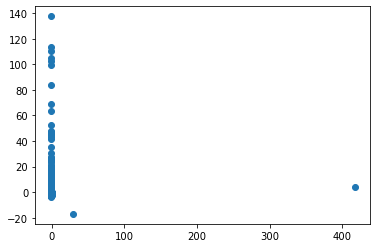

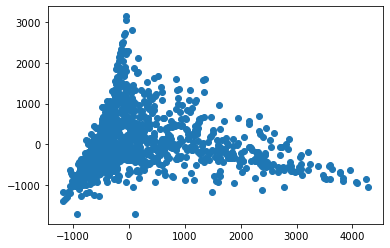

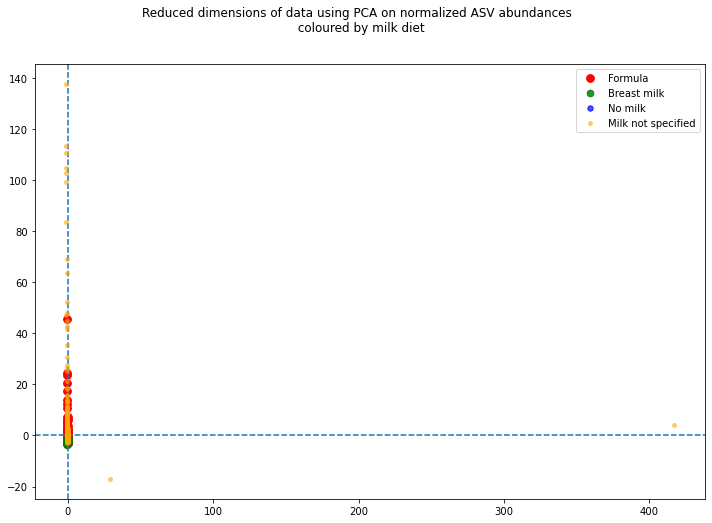

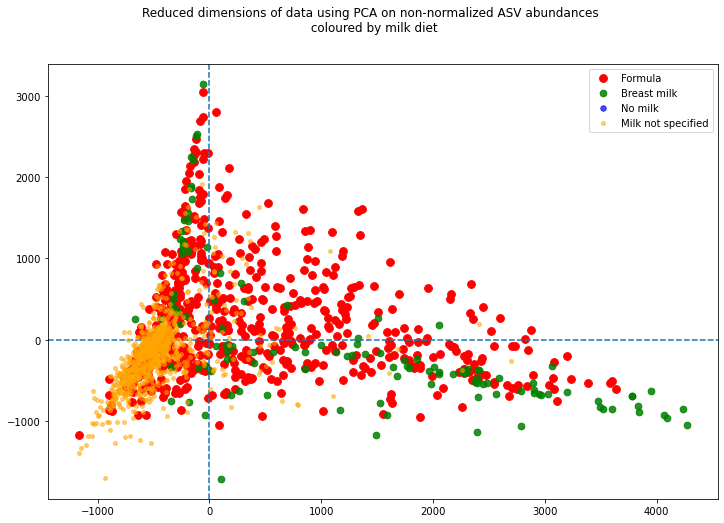

In [60]:
ASV_metadata_normal = scaler(table_ASV_metadata, ASVs_cols)
principalComponents_ASV = PCA_apply(ASV_metadata_normal, ASVs_cols)
principalComponents_notnormal_ASV = PCA_apply(table_ASV_metadata, ASVs_cols)
pca_milk_plot(table_ASV_metadata, principalComponents_ASV, 'PCA on normalized ASV abundances')
pca_milk_plot(table_ASV_metadata, principalComponents_notnormal_ASV, 'PCA on non-normalized ASV abundances')

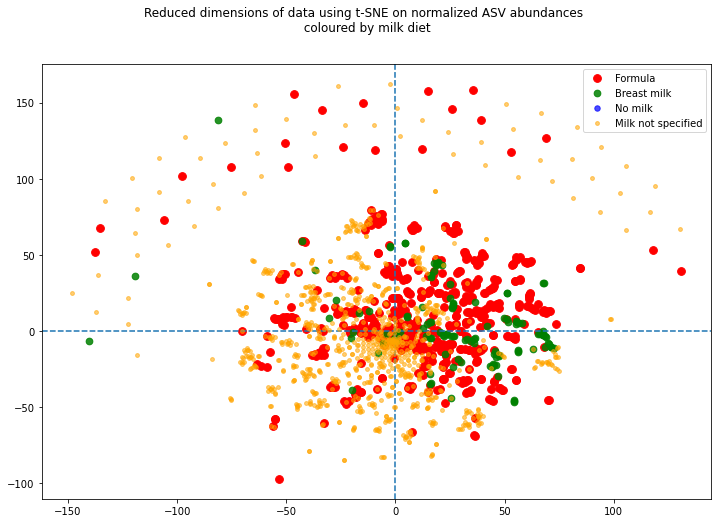

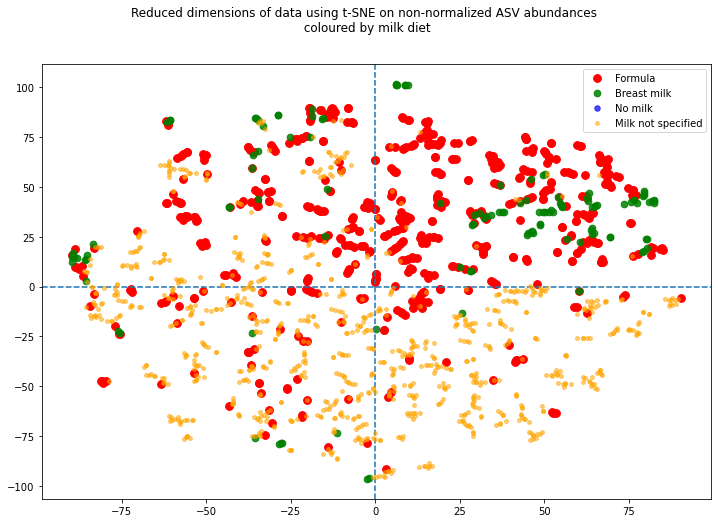

In [63]:
t_SNE_taxonomy_ASV = fit_tSNE(ASV_metadata_normal[ASVs_cols])
t_SNE_taxonomy_notnormal_ASV = fit_tSNE(table_ASV_metadata[ASVs_cols])
pca_milk_plot(table_ASV_metadata, t_SNE_taxonomy_ASV, 't-SNE on normalized ASV abundances')
pca_milk_plot(table_ASV_metadata, t_SNE_taxonomy_notnormal_ASV, 't-SNE on non-normalized ASV abundances')

## More ideas
* PCA: remove outliers before doing PCA. How to find these outliers? E.g. the point with very high 2nd dimension in the plot. 
* Neural net with 2 inputs: the taxonomic assignment vector for 2 babies. Output: monozygotic, dizygotic, unrelated. 